In [30]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [31]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [32]:
dir = '../../data_vectors/cosmodc2/2022/star_sample/Sep14/chains/'
dir2 = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
nlbins = 5

name_plots = 'wcdm'

chainfile_0 = dir + 'cosmodc2_3x2pt_fourier_w0-wa.txt'
name_0 = r'Harmonic $\textsc{CosmoDC2}$'

chainfile_1 = dir + 'cosmodc2_3x2pt_real_w0-wa.txt'
name_1 = r'Real $\textsc{CosmoDC2}$'

chainfile_2 = dir2 + 'gaussian_sims_3x2pt_fourier_w0-wa.txt'
name_2 = r'Harmonic LSST-Y1 GaussSim'

chainfile_3 = dir2 + 'gaussian_sims_3x2pt_real_w0-wa.txt'
name_3 = r'Real LSST-Y1 GaussSim'

chainfile_4 = dir2 + 'prior_3x2pt_wcdm.txt'
name_4 = r'Prior'

#chainfile_3 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa_fixed_sys.txt'
#name_3 = r'Fourier space fixed sys.'

#chainfile_1 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt' #this had wider priors on ns and omega_b
#name_1 = r'Fourier $w$CDM'

colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']


In [33]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
chain_2 = np.loadtxt(chainfile_2)
chain_3 = np.loadtxt(chainfile_3)
chain_4 = np.loadtxt(chainfile_4)
print(len(chain_0))
print(len(chain_1))
print(len(chain_2))
print(len(chain_3))
print(len(chain_4))

247680
195200
256640
259600
20000


In [34]:
get_names(chainfile_0), get_names(chainfile_3)

(array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
        'cosmological_parametersn_s', 'cosmological_parametersa_s',
        'cosmological_parametersh0', 'cosmological_parametersw',
        'cosmological_parameterswa', 'firecrown_two_pointia_bias',
        'firecrown_two_pointalphaz',
        'firecrown_two_pointsource_0_mult_bias',
        'firecrown_two_pointsource_1_mult_bias',
        'firecrown_two_pointsource_2_mult_bias',
        'firecrown_two_pointsource_3_mult_bias',
        'firecrown_two_pointsource_4_mult_bias',
        'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
        'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
        'firecrown_two_pointlens_4_bias',
        'firecrown_two_pointlens_0_delta_z',
        'firecrown_two_pointlens_1_delta_z',
        'firecrown_two_pointlens_2_delta_z',
        'firecrown_two_pointlens_3_delta_z',
        'firecrown_two_pointlens_4_delta_z',
        'firecrown_two_

In [35]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars

def get_pars(chainfile, parnames, burnin, chain):
    indices = get_indices(chainfile, parnames)    
    chain_sel = chain[burnin:,indices]
    chain_sel.T[3] = chain_sel.T[3]*10**9  #normalize A_s
    return chain_sel

def get_prior_chain(filename, list_vars, chain):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    chain_ind = chain[:,indices]
    mask_nans = ~np.isnan(chain_ind.T[0])
    chain_ind_no_nans = chain_4[:,indices][mask_nans]
    return chain_ind_no_nans

## Plot cosmological parameters

In [36]:
# FireCrown names
cosmo_parnames = ['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
       'cosmological_parametersn_s', 'cosmological_parametersa_s', 'cosmological_parametersh0', 'COSMOLOGICAL_PARAMETERSSIGMA_8','COSMOLOGICAL_PARAMETERSOMEGA_M']
cosmo_names = ['$\Omega_c$','$\Omega_b$','$n_s$','$A_s$','$h$','$\sigma_8$','$\Omega_m$']
cosmo_truths = [2.199999e-01, 4.479270e-02, 9.630000e-01, 2.16e-9, 0.71,  8.000000e-01,  2.647887e-01]

In [9]:
cosmo_names_prior = ['$\Omega_c$','$\Omega_b$','$n_s$', '$A_s$', '$h$']
cosmo_truths_prior = [2.199999e-01, 4.479270e-02, 9.630000e-01, 2.16e-9, 0.71]
widths = np.array([0.2,0.006,0.08,3.78e-10,0.063])
prior = np.random.multivariate_normal(cosmo_truths_prior,np.diagflat(widths**2),1000)

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccc}
        \hline
		Model & $\Omega_m$ & $S_8$ & $w_0$ & $w_a$ \\ 
		\hline
		Prior & $0.230^{+0.081}_{-0.088}$ & $0.60^{+0.38}_{-0.37}$ & $-1.11^{+0.49}_{-0.52}$ & $-0.37^{+0.86}_{-0.98}$ \\ 
		Harmonic $\textsc{CosmoDC2}$ & $0.295^{+0.024}_{-0.031}$ & $0.741^{+0.020}_{-0.022}$ & $-0.85^{+0.30}_{-0.31}$ & $-0.52^{+0.75}_{-0.86}$ \\ 
		Real $\textsc{CosmoDC2}$ & $0.277^{+0.033}_{-0.031}$ & $0.742\pm 0.023$ & $-0.92\pm 0.30$ & $-0.07^{+0.74}_{-0.95}$ \\ 
		Harmonic LSST-Y1 GaussSim & $0.263^{+0.021}_{-0.016}$ & $0.748\pm 0.012$ & $-1.09\pm 0.18$ & $0.27^{+0.43}_{-0.47}$ \\ 
		Real LSST-Y1 GaussSim & $0.269^{+0.019}_{-0.018}$ & $0.757\pm 0.011$ & $-1.03^{+0.16}_{-0.15}$ & $0.18^{+0.37}_{-0.44}$ \\ 
		\hline
    \end{tabular}
\end{table}


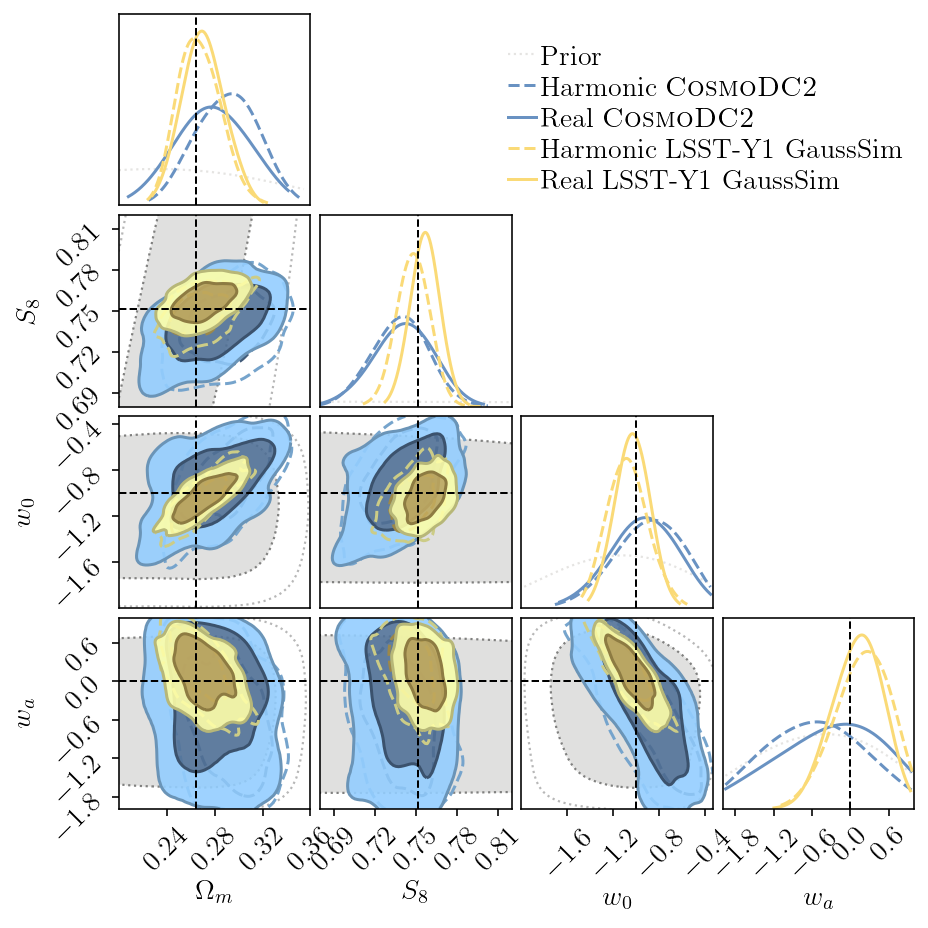

In [39]:
# FireCrown names
cosmo_parnames = [ 'COSMOLOGICAL_PARAMETERSOMEGA_M', 'COSMOLOGICAL_PARAMETERSS_8','cosmological_parametersw','cosmological_parameterswa' ]
cosmo_names = ['$\Omega_m$', '$S_8$', '$w_0$', '$w_a$']#'$\sigma_8$',]
cosmo_truths = [2.647887e-01, 0.7515866949, -1, 0]#,#8.000000e-01]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_indices(chainfile_1, cosmo_parnames)
cosmo2 = get_indices(chainfile_2, cosmo_parnames)
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo4 = get_prior_chain(chainfile_4, cosmo_parnames, chain_4) # Omega_m has nans in it

c = ChainConsumer()
#c.add_chain(chain_0[:,cosmo0], parameters=cosmo_names_lcdm, name=name_0, weights=chain_0[:,-1])
#c.add_chain(prior, parameters=cosmo_names_prior, name="Prior")
c.add_chain(cosmo4, parameters=cosmo_names, name=name_4)
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(chain_1[burnin:,cosmo1], parameters=cosmo_names, name=name_1)
c.add_chain(chain_2[burnin:,cosmo2], parameters=cosmo_names, name=name_2)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)


def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.,1,1], shade=[True, False,True,False,True,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":", "--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)

table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(4.,4.), truth=cosmo_truths, extents=[(0.2, 0.36), (0.68, 0.82)])
fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_om_S8_w_prior.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_om_S8_w_prior.pdf'%(name_plots, burnin), bbox_inches="tight",)


In [40]:
# FireCrown names
cosmo_parnames = [ 'COSMOLOGICAL_PARAMETERSOMEGA_M', 'COSMOLOGICAL_PARAMETERSS_8','cosmological_parametersw','cosmological_parameterswa' , 'COSMOLOGICAL_PARAMETERSSIGMA_8',]
cosmo_names = ['$\Omega_m$', '$S_8$', '$w_0$', '$w_a$','$\sigma_8$',]
cosmo_truths = [2.647887e-01, 0.7515866949, -1, 0,8.000000e-01]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_indices(chainfile_1, cosmo_parnames)
cosmo2 = get_indices(chainfile_2, cosmo_parnames)
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo4 = get_prior_chain(chainfile_4, cosmo_parnames, chain_4) # Omega_m has nans in it

c = ChainConsumer()
#c.add_chain(chain_0[:,cosmo0], parameters=cosmo_names_lcdm, name=name_0, weights=chain_0[:,-1])
#c.add_chain(prior, parameters=cosmo_names_prior, name="Prior")
c.add_chain(cosmo4, parameters=cosmo_names, name=name_4)
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(chain_1[burnin:,cosmo1], parameters=cosmo_names, name=name_1)
c.add_chain(chain_2[burnin:,cosmo2], parameters=cosmo_names, name=name_2)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)


def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.,1,1], shade=[True, False,True,False,True,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":", "--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)

table = c.analysis.get_latex_table()
print(table)

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_m$ & $S_8$ & $w_0$ & $w_a$ & $\sigma_8$ \\ 
		\hline
		Prior & $0.230^{+0.081}_{-0.088}$ & $0.60^{+0.38}_{-0.37}$ & $-1.11^{+0.49}_{-0.52}$ & $-0.37^{+0.86}_{-0.98}$ & $0.72^{+0.31}_{-0.33}$ \\ 
		Harmonic $\textsc{CosmoDC2}$ & $0.295^{+0.024}_{-0.031}$ & $0.741^{+0.020}_{-0.022}$ & $-0.85^{+0.30}_{-0.31}$ & $-0.52^{+0.75}_{-0.86}$ & $0.750^{+0.036}_{-0.034}$ \\ 
		Real $\textsc{CosmoDC2}$ & $0.277^{+0.033}_{-0.031}$ & $0.742\pm 0.023$ & $-0.92\pm 0.30$ & $-0.07^{+0.74}_{-0.95}$ & $0.769^{+0.041}_{-0.039}$ \\ 
		Harmonic LSST-Y1 GaussSim & $0.263^{+0.021}_{-0.016}$ & $0.748\pm 0.012$ & $-1.09\pm 0.18$ & $0.27^{+0.43}_{-0.47}$ & $0.798^{+0.021}_{-0.029}$ \\ 
		Real LSST-Y1 GaussSim & $0.269^{+0.019}_{-0.018}$ & $0.757\pm 0.011$ & $-1.03^{+0.16}_{-0.15}$ & $0.18^{+0.37}_{-0.44}$ & $0.796^{+0.025}_{-0.023}$ \\ 
		\hline
    \end{tabular}
\end{table}


In [ ]:
# FireCrown names
bias_parnames = [ 'firecrown_two_pointlens_%s_bias'%(l) for l in range(5)]
bias_names = ['$b_1$','$b_2$', '$b_3$', '$b_4$', '$b_5$']
bias_truths = [0.87, 1.02, 1.19, 1.30, 1.54]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 100000

bias0 = get_indices(chainfile_0, bias_parnames)
bias1 = get_indices(chainfile_1, bias_parnames)
bias4 = get_indices(chainfile_4, bias_parnames)

c = ChainConsumer()
c.add_chain(chain_4[:,bias4], parameters=bias_names, name=name_4)
c.add_chain(chain_0[burnin:,bias0], parameters=bias_names, name=name_0)
c.add_chain(chain_1[burnin:,bias1], parameters=bias_names, name=name_1)


def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,1,1,1], shade=[True, True,False,False,True,False, False], shade_alpha=0.9, bar_shade=False,colors=["#E5E4E2",colors[1],colors[1],  colors[3], colors[3]],legend_kwargs={"fontsize": 14, 'loc':"lower right"},
            legend_color_text=False, tick_font_size=14, label_font_size=14, linewidths=[1.1, 1.5, 1.5,1.5, 1.5, 1.1, 2.5, 1], linestyles=[":","--", "-","--", "-","-", "-", "--",":"])
    return c

c = call_configure(c)

fig = c.plotter.plot(figsize=(3.,3.), truth=bias_truths)
fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/bias_%s_%d.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/bias_%s_%d.pdf'%(name_plots, burnin), bbox_inches="tight",)
